# Speech Commands recognition using ConvNets in PyTorch (Tutorial)

This is a tutorial post on speech commands recognition using the [Speech Commands dataset](https://arxiv.org/abs/1804.03209). The goals are  

1. Work with audio data using torchaudio: look at spectrograms features
2. Train a model to recogize audio data from a vocabulary of spoken commands
3. Evaluate model performance using measures like accuracy (error rate), false alarm, confusion matrix

There are around 10 speech commands like Yes, No, Up, Down and so on. The dataset is contains wav files sampled at 16000Hz and contains upto a second of data. In addition to the commands themselves, there are some words that are not commands and background files containing background noise and silence segments. 

We will rely heavily on the torchaudio package, which has some convenient dataloaders and feature preprocessing. The nice thing about torchaudio, is that the feature processing can take place on the GPU and this will accelerate the training process significantly.

To install torchaudio, the command below should be executed in a terminal:  
conda install -c pytorch torchaudio

The -c option searches on the pytorch channel.  

This notebook is available on github at this [link].(https://github.com/jumpml/pytorch-tutorials/blob/master/SpeechCommands_CNN.ipynb)

In [3]:
# CUSTOMARY IMPORTS
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import SpeechCommandsDataset as scd

%matplotlib inline

random_seed = 1        
torch.manual_seed(random_seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.is_available()

True

## Data  Setup

We have created a wrapper around torchaudio's SPEECHCOMMANDS dataset class. The wrapper performs the following steps for us  
1. Create train, val and test splits of the dataset 
2. Process the background noise files and creates 1 sec segments for augmenting each split
3. Pad the data to 1s and map the string labels to integer. Number 11 corresponds to background or unknown. 
4. Creates dataloaders for each split with appropriate transform (MelSpectrogram)

The torchaudio class automatically downloads the data if not already on disk. If we look at the source code for the speechcommands dataset class in torchaudio, we need to specify the version of speech commands (v0.2). The dataset is around 2.3GB in size. Each item in the dataloader consists of the following information:  
waveform, sample_rate, label, speaker_id, utterance_number. 

In this tutorial, we are not using speaker_id or utterance_number. We are not downsampling the audio to 8kHz, which may be a good thing to do, since it is an effective way to throw away information that is not related to the task of recognizing commands. Most of the voice information is between 20 Hz to 3.6 kHz.

### Feature Pre-Processing



In [5]:
batch_size_train = 64
# Setup train, val and test dataloaders
sc_data = scd.SpeechCommandsData(train_bs=batch_size_train, test_bs=64, val_bs=64, n_mels=40)

Found existing background directory. Removing files in that directory.
Initialize/download SpeechCommandsDataset....

SpeechCommands Dataset Size: 105829

Generate 1s background files:

Background files generated: 220

Extracting training dataset files...
Train dataset extracted: 84843 files 

Extracting test and val dataset files...
Validation dataset extracted: 9981 files
Test dataset extracted: 11005 files


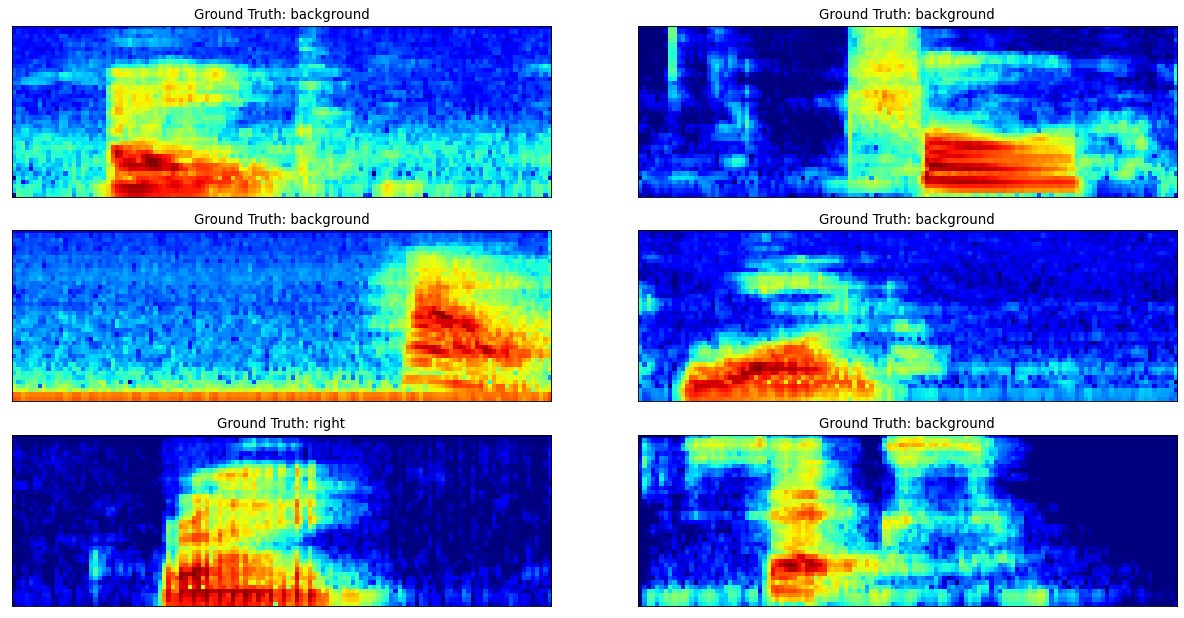

In [6]:
# The enumerate() method adds a counter to an iterable and returns an enumerate object
examples = enumerate(sc_data.test_loader)
batch_idx, (example_X, example_y) = next(examples)

# VISUALIZE SOME EXAMPLES
fig=plt.figure(figsize=(16, 8), dpi=80)
for i in range(6):
  plt.subplot(3,2,i+1)
  plt.tight_layout()
  plt.imshow(torch.squeeze(example_X[i]), cmap='jet', origin='lower')
  plt.title("Ground Truth: {}".format(scd.KNOWN_COMMANDS[int(example_y[i])]))
  plt.xticks([])
  plt.yticks([])

In [7]:
example_X.shape

torch.Size([64, 1, 40, 126])

## Model Specification

Our model is going to be simple:   
Input X (B,1,40,126)  
--> Conv2D(1,10,7) --> MaxPool2D(2) --> ReLU  
--> Conv2D(10,5,3) --> MaxPool2D(2) --> ReLU  
--> Linear(100)    --> Dropout(0.2) --> ReLU  
--> Linear(10)     --> LogSoftmax  


where B is Batch Size, the arguments to Conv2D are input numChannels, output numChannels and kernel size.

In [8]:
def get_conv_size(in_dim, kernel_size, stride=1, padding=0, dilation=1):
    return ( (in_dim + 2*padding - dilation * (kernel_size - 1) - 1) // stride  + 1)

In [9]:
input_size = (40,126)    # Spectrogram has 40 x 126 input images
C1_kernel_size = (8,20) # Customary to use odd and square kernel/filter size fxf 
num_filters_conv1 = 12
num_filters_conv2 = 12  
C2_kernel_size = (4,10) # Customary to use odd and square kernel/filter size fxf 
mp2d_size = 2      # MaxPooling2d window size (= stride)
fc1_out_size = 64
fc2_out_size = 11  # 10 commands and 1 background class

C1 = (get_conv_size(input_size[0], C1_kernel_size[0]), 
      get_conv_size(input_size[1], C1_kernel_size[1]))         # C1: size after conv1 
MP1 = (get_conv_size(C1[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C1[1], mp2d_size, stride = mp2d_size)) # MP1: size after max_pool2d
C2 = (get_conv_size(MP1[0], C2_kernel_size[0]),
       get_conv_size(MP1[1], C2_kernel_size[1]))               # C2: size after conv2 
MP2 = (get_conv_size(C2[0], mp2d_size, stride = mp2d_size),
       get_conv_size(C2[1], mp2d_size, stride = mp2d_size)) # MP2: size after max_pool2d
fc1_in_size = MP2[0]*MP2[1] * num_filters_conv2                   # pixels * num_filters

print(f'C1:{C1} MP1:{MP1}   C2:{C2} MP2:{MP2}    FC1_in:{fc1_in_size}')

C1:(33, 107) MP1:(16, 53)   C2:(13, 44) MP2:(6, 22)    FC1_in:1584


In [10]:
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_filters_conv1, kernel_size=C1_kernel_size)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, C2_kernel_size)
        self.fc1 = nn.Linear(fc1_in_size, fc1_out_size)
        self.fc2 = nn.Linear(fc1_out_size, fc2_out_size)           # number of classes = 11

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), mp2d_size))
        x = F.relu(F.max_pool2d(self.conv2(x), mp2d_size))
        x = x.view(-1, fc1_in_size)    # reshape
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)  # Apply dropout only during training
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

nnModel = model().to(device)       # Instantiate our model and move model to GPU if available

## Objective or Loss Function
In the model the final layer is a log-softmax function, in orderwords we get a vector of per-utterance log probabilities or log-likelihoods. So the output of the model is basically 
$$ \hat{y} = \log P(y | x) $$

If we combine this with the nll_loss, which stands for negative log-likelihood loss which basically does the following operation  
$$
l(\hat{y},y) = -\hat{y}[y]
$$

where $y$ is the true class label in ${0,1,...,C-1}$. If the model predicted the correct command with probability 1.0, then this loss would be 0.0. Otherwise it would be a positive number. By combining log-softmax and NLL loss, we get the Cross Entropy Loss. 

In [11]:
# Define objective function
lossFn = F.nll_loss  #When we combine nll_loss and log_softmax we get a cross entropy loss

## Model Optimization or Training 
The new parameters are the previous parameters with a step (proportional to learning rate $\mu$) in the direction (negative gradient of loss function w.r.t parameters) that reduces the loss function. In terms of math for a single labeled example $y$ and model prediction $\hat{y}$  
$$ W_n = W_{n-1} - \mu \nabla_{W} l(\hat{y},y) $$

For a batch of examples, we simply replace the loss above with some reduction such as the mean loss over the batch. 


In [39]:
learning_rate = 0.001   # Learning rate for optimizer like SGD usually in [0.001, 0.1]
# Define optimization
optimizer = optim.SGD(nnModel.parameters(), lr=learning_rate, momentum=0.5)

## Mechanics of Training
Basically has the following steps which we repeat until all batches of training data are consumed
1. Get a batch of inputs (X) and corresponding labels (y), move to device
2. Initialize gradients
3. Calculate loss function on current batch of inputs and labels
4. Calculate gradients by calling backward() on the loss function output
5. Update parameters by calling optimizer.step()

In [40]:
train_losses = []
log_frequency = 100
TrainLen = len(sc_data.train_loader.dataset)
def train(model, lossFn, optimizer, train_loader):
  model.train()
  for batch_idx, (X_train, y_train) in enumerate(train_loader):
    # Move to device
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Initialize gradients
    optimizer.zero_grad()
    # Predict on current batch of data
    y_hat = model(X_train)
    # Calculate Average Loss
    loss = lossFn(y_hat, y_train)
    # Calculate Gradients
    loss.backward()
    # Update model parameters using SGC
    optimizer.step()
    if batch_idx % log_frequency == 0:
      print(f'Train  {batch_idx * len(X_train)}/{TrainLen} Loss:{loss.item()}\n')
      train_losses.append(loss.item())



In [41]:
device

device(type='cuda', index=0)

In [42]:
val_losses = []

def evalModel(model, lossFn, dataloader, mode='Val'):
  model.eval()
  loss = 0
  correct = 0
  with torch.no_grad():
    for X_test, y_test in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_hat = model(X_test)
      loss += lossFn(y_hat, y_test).item()
      pred = y_hat.data.max(1, keepdim=True)[1]
      correct += pred.eq(y_test.data.view_as(pred)).sum()
  loss /= len(dataloader.dataset)
  val_losses.append(loss)
  accuracy = 100. * correct / len(dataloader.dataset)
  print(f'\n{mode} set: Avg. loss: {loss:.4f}, Accuracy: {accuracy} %\n')
  return(accuracy)

In [43]:
val_accuracy = []
n_epochs = 5
val_accuracy.append(evalModel(nnModel, lossFn, sc_data.val_loader))
for epoch in range(1, n_epochs + 1):
  train(nnModel, lossFn, optimizer, sc_data.train_loader)
  val_accuracy.append(evalModel(nnModel, lossFn, sc_data.val_loader))


Val set: Avg. loss: 0.0064, Accuracy: 87.21894073486328 %

Train  0/85069 Loss:0.29128608107566833

Train  6400/85069 Loss:0.20726865530014038

Train  12800/85069 Loss:0.21667072176933289

Train  19200/85069 Loss:0.1711825132369995

Train  25600/85069 Loss:0.2798224985599518

Train  32000/85069 Loss:0.15612009167671204

Train  38400/85069 Loss:0.3359333872795105

Train  44800/85069 Loss:0.2317049652338028

Train  51200/85069 Loss:0.05412425845861435

Train  57600/85069 Loss:0.23456047475337982

Train  64000/85069 Loss:0.26664236187934875

Train  70400/85069 Loss:0.29691824316978455

Train  76800/85069 Loss:0.22551149129867554

Train  83200/85069 Loss:0.3131025433540344


Val set: Avg. loss: 0.0055, Accuracy: 89.48735809326172 %

Train  0/85069 Loss:0.12018810212612152

Train  6400/85069 Loss:0.20511572062969208

Train  12800/85069 Loss:0.13723093271255493

Train  19200/85069 Loss:0.20685352385044098

Train  25600/85069 Loss:0.17587485909461975

Train  32000/85069 Loss:0.24534335732460

Text(0, 0.5, 'negative log likelihood loss')

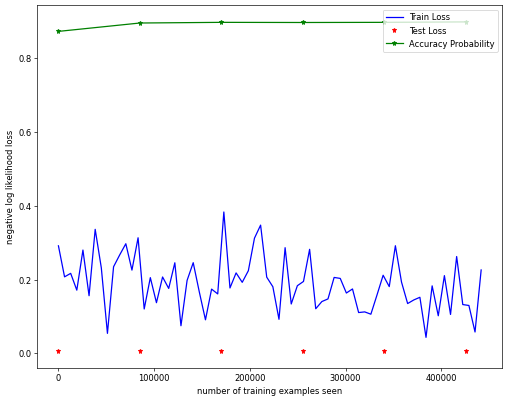

In [44]:
fig=plt.figure(figsize=(10, 8), dpi=60)
x = range(0,log_frequency*len(train_losses)*batch_size_train,log_frequency*batch_size_train)
plt.plot(x, train_losses, color='blue')
x = range(0, TrainLen*len(val_losses), TrainLen)
plt.plot(x,val_losses,'r*')
plt.plot(x,np.array(val_accuracy)/100.0,'g*-')
plt.legend(['Train Loss', 'Test Loss', 'Accuracy Probability'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [57]:
evalModel(nnModel, lossFn, sc_data.test_loader)


Val set: Avg. loss: 0.0060, Accuracy: 88.78919982910156 %



tensor(88.7892, device='cuda:0')